In [2]:
import numpy as np
import matplotlib.pyplot as plt
from spectral import *
from scipy import linalg
import scipy.stats as stats
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import euclidean
from scipy.stats import f_oneway
import pandas as pd
import cv2
import glob
import os

In [33]:
class DataProcessor():
    def __init__(self, leuko_data_dir, leuko_rgbs_dir, scc_data_dir, scc_rgbs_dir, hh_data_dir, hh_rgbs_dir):

        #Leuko Data
        self.leuko_data_dir = leuko_data_dir
        self.leuko_rgbs_dir = leuko_rgbs_dir

        self.leuko_imgs = []
        self.leuko_rgbs = []
        self.leuko_data_name = []
        self.leuko_rgbs_name = []

        #OSCC Data
        self.scc_data_dir = scc_data_dir
        self.scc_rgbs_dir = scc_rgbs_dir

        self.scc_imgs = []
        self.scc_rgbs = []
        self.scc_data_name = []
        self.scc_rgbs_name = []

        #Healthy Data
        self.hh_data_dir = hh_data_dir
        self.hh_rgbs_dir = hh_rgbs_dir

        self.hh_imgs = []
        self.hh_rgbs = []
        self.hh_data_name = []
        self.hh_rgbs_name = []
                 
    def load_multispectral_data(self, data_dir, imgs_list, data_name):
        # msi_files = data_dir 
        msi_files = glob.glob(os.path.join(data_dir))
        for msi_file in msi_files:
            img_data = open_image(msi_file)
            imgs_list.append(np.asarray(img_data.load()))
            img_filename = os.path.basename(msi_file)
            data_name.append(img_filename)

    def load_rgbs(self, rgbs_dir, rgbs_list, rgbs_name):
        # rgb_files = rgbs_dir
        rgb_files = glob.glob(os.path.join(rgbs_dir))
        for rgb_file in rgb_files:
            rgb_im = cv2.imread(rgb_file)
            rgb_im = cv2.cvtColor(rgb_im, cv2.COLOR_BGR2RGB)
            rgbs_list.append(rgb_im)
            rgb_filename = os.path.basename(rgb_file)
            rgbs_name.append(rgb_filename)

    def process_data(self):
        self.load_multispectral_data(self.leuko_data_dir, self.leuko_imgs, self.leuko_data_name)
        self.load_rgbs(self.leuko_rgbs_dir, self.leuko_rgbs, self.leuko_rgbs_name)

        self.load_multispectral_data(self.scc_data_dir, self.scc_imgs, self.scc_data_name)
        self.load_rgbs(self.scc_rgbs_dir, self.scc_rgbs, self.scc_rgbs_name)

        self.load_multispectral_data(self.hh_data_dir, self.hh_imgs, self.hh_data_name)
        self.load_rgbs(self.hh_rgbs_dir, self.hh_rgbs, self.hh_rgbs_name)                


In [61]:
# Create an instance of the DataProcessor class and process the data
# "C:\Users\htic\Documents\Jupyter\MSI_Oral_Analysis\NIR\Leuko\data\001.raw"
#C:\Users\htic\Documents\Jupyter\MSI_Oral_Analysis\NIR\SCC
base_dir = "C:/Users/htic/Documents/Jupyter/MSI_Oral_Analysis/NIR/"
data_processor = DataProcessor(
    #Reading Leuko Data
    leuko_data_dir = os.path.join(base_dir, "Leuko/data/*.hdr"),
    leuko_rgbs_dir = os.path.join(base_dir, "Leuko/rgbs/*.png"),

    scc_data_dir = os.path.join(base_dir,"SCC/data/*.hdr"),
    scc_rgbs_dir = os.path.join(base_dir, "SCC/rgbs/*.png"), 

    hh_data_dir = os.path.join(base_dir,"HH/data/*.hdr"),
    hh_rgbs_dir = os.path.join(base_dir, "HH/rgbs/*.png")
)
data_processor.process_data()
leuko_imgs = data_processor.leuko_imgs
scc_imgs = data_processor.scc_imgs
hh_imgs = data_processor.hh_imgs

leuko_rgbs = data_processor.leuko_rgbs
scc_rgbs = data_processor.scc_rgbs
hh_rgbs = data_processor.hh_rgbs

In [62]:
for i in range(len(leuko_imgs)):
    print(leuko_imgs[i].shape)

(215, 407, 24)
(215, 407, 24)
(215, 407, 24)
(215, 407, 24)
(215, 407, 24)
(215, 407, 24)
(215, 407, 24)


In [63]:
bands = [670,682,695,706,722,733,747,761,775,783,799,810,822,837,847,859,871,883,891,906,915,923,931,933]
def oxy_cal(img):
   # R706 = 302.8, 1634.48
   # R799 = 807.2, 782.36 
    attmat = np.array([[302.8, 1634.48],[807.2, 782.36]])

    lnR706 = np.log(img[:,:,10])  #changing reflectance to absorbance
    lnR799 = np.log(img[:,:,4])  #800

    # has_inf = np.isinf(lnR706).any()

    # if has_inf:
    #     print("The image contains inf values.")
 
    lnR706 = np.nan_to_num(lnR706)
    lnR799 = np.nan_to_num(lnR799)

    # hbO2 = []
    # Hbb = []
    lnR706 = lnR706.reshape(215*407)
    lnR799 = lnR799.reshape(215*407)
    
    y = np.linalg.lstsq(attmat, [lnR706, lnR799])[0]
    hbo2 = y[0]
    hb = y[1]
    hbO2 = hbo2.reshape(215,407)
    Hbb = hb.reshape(215,407)

    #normalizing Hb, Hb02 values before calculating st02
    n_Hb = ((Hbb- Hbb.min())/(Hbb.max()-Hbb.min()))*100
    n_HbO2 = ((hbO2- hbO2.min()) / (hbO2.max() - hbO2.min()))*100

    StO2 = n_HbO2/(n_Hb+n_HbO2)
    n_StO2 = ((StO2 - StO2.min()))/(StO2.max() - StO2.min())*100        
    return n_Hb, n_HbO2, n_StO2

C:\Users\htic\AppData\Local\Temp\ipykernel_29564\3052452885.py:7: RuntimeWarning: invalid value encountered in log
  lnR706 = np.log(img[:,:,10])  #changing reflectance to absorbance
C:\Users\htic\AppData\Local\Temp\ipykernel_29564\3052452885.py:8: RuntimeWarning: invalid value encountered in log
  lnR799 = np.log(img[:,:,4])  #800
C:\Users\htic\AppData\Local\Temp\ipykernel_29564\3052452885.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  y = np.linalg.lstsq(attmat, [lnR706, lnR799])[0]


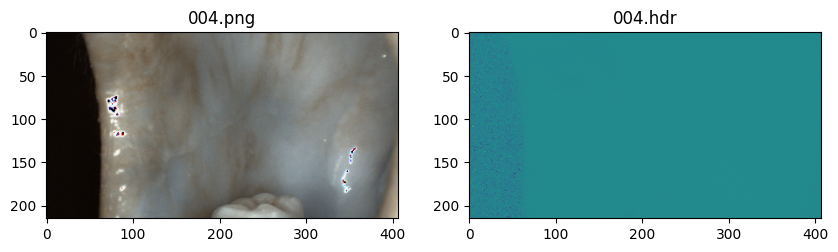

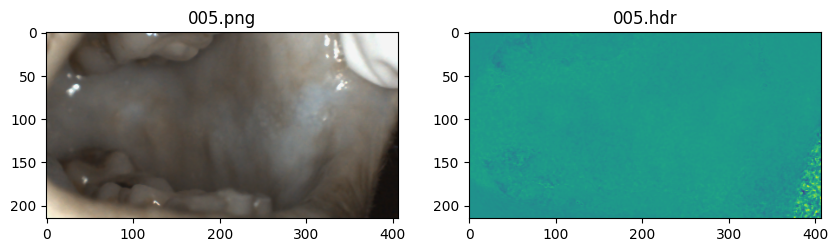

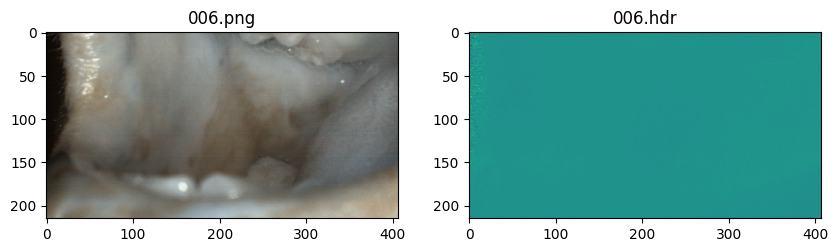

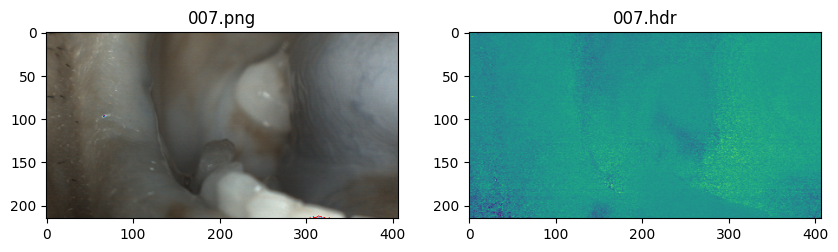

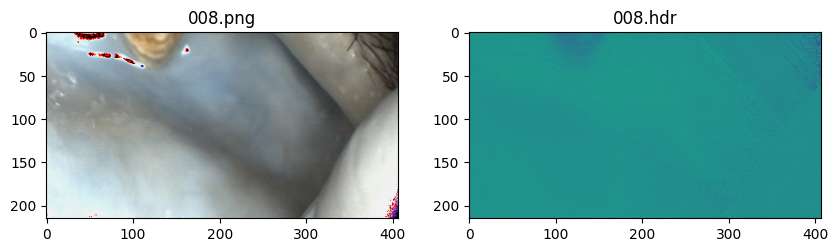

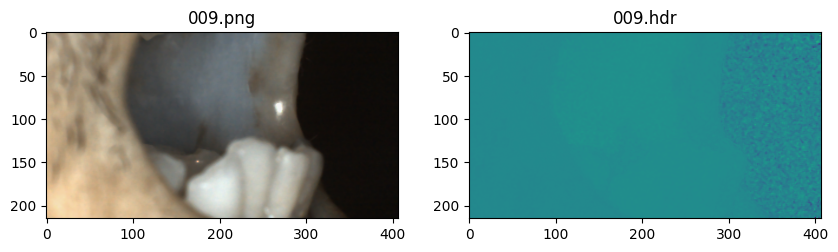

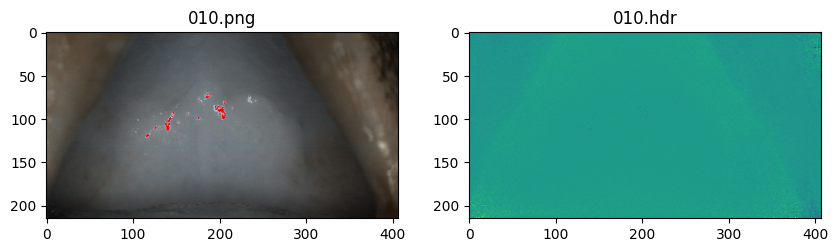

In [67]:
leuko_sto2 = []
for i in range(len(leuko_imgs)):
    img = leuko_imgs[i]
    rgb = leuko_rgbs[i]
    Hb,HbO2, StO2 = oxy_cal(img)
    leuko_sto2.append(StO2)
    plt.figure(figsize=(10,20))
    plt.subplot(1,2,1), plt.imshow(rgb), plt.title(data_processor.leuko_rgbs_name[i])
    plt.subplot(1,2,2), plt.imshow(StO2), plt.title(data_processor.leuko_data_name[i])
    plt.show()

C:\Users\htic\AppData\Local\Temp\ipykernel_29564\3052452885.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  y = np.linalg.lstsq(attmat, [lnR706, lnR799])[0]


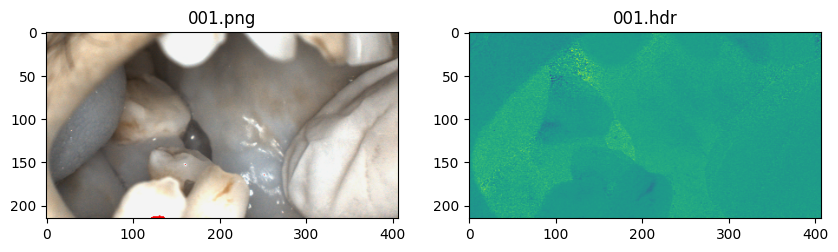

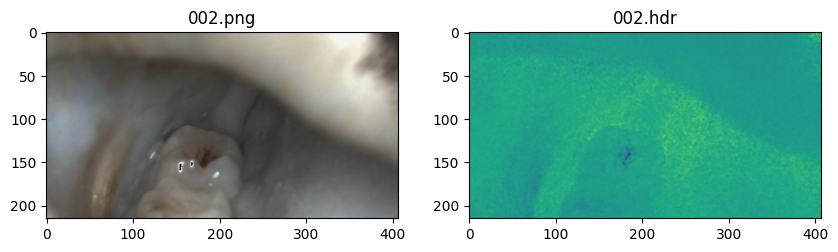

C:\Users\htic\AppData\Local\Temp\ipykernel_29564\3052452885.py:7: RuntimeWarning: invalid value encountered in log
  lnR706 = np.log(img[:,:,10])  #changing reflectance to absorbance
C:\Users\htic\AppData\Local\Temp\ipykernel_29564\3052452885.py:8: RuntimeWarning: invalid value encountered in log
  lnR799 = np.log(img[:,:,4])  #800


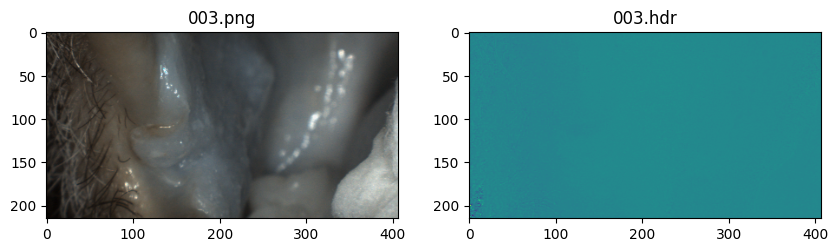

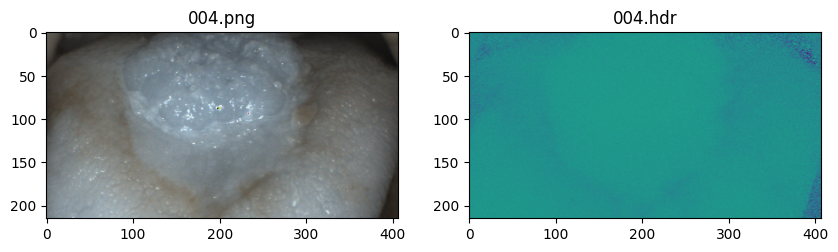

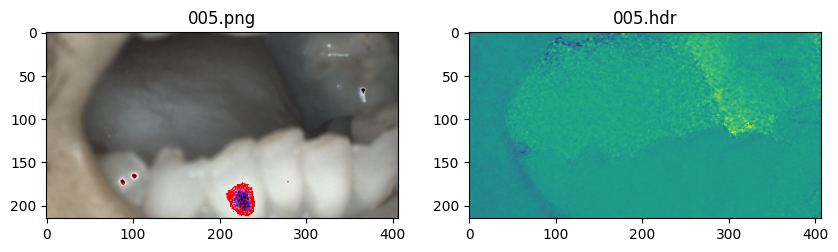

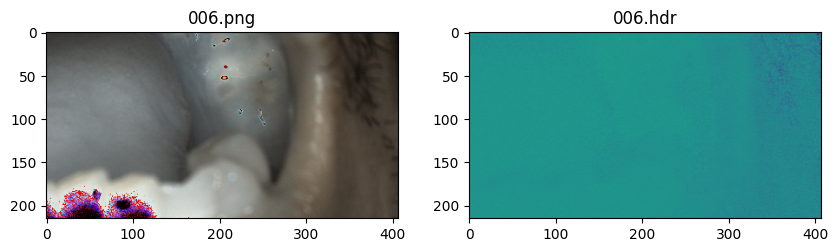

In [68]:
scc_sto2 = []
for i in range(len(scc_imgs)):
    img = scc_imgs[i]
    rgb = scc_rgbs[i]
    Hb,HbO2, StO2 = oxy_cal(img)
    scc_sto2.append(StO2)
    plt.figure(figsize=(10,20))
    plt.subplot(1,2,1), plt.imshow(rgb), plt.title(data_processor.scc_rgbs_name[i])
    plt.subplot(1,2,2), plt.imshow(StO2), plt.title(data_processor.scc_data_name[i])
    plt.show()

C:\Users\htic\AppData\Local\Temp\ipykernel_29564\3052452885.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  y = np.linalg.lstsq(attmat, [lnR706, lnR799])[0]


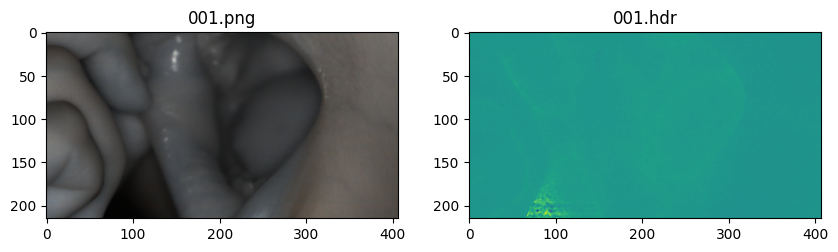

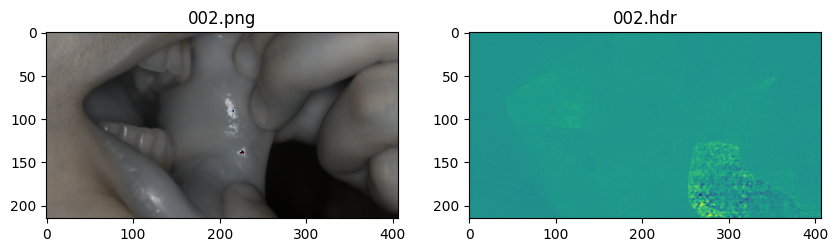

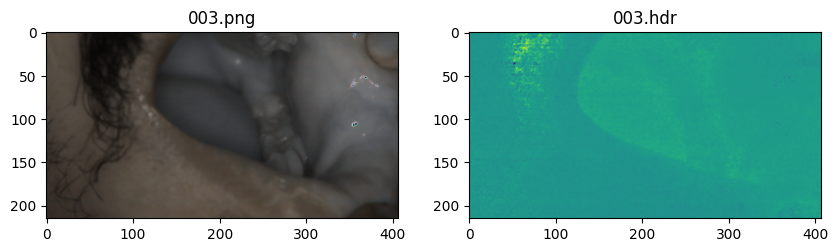

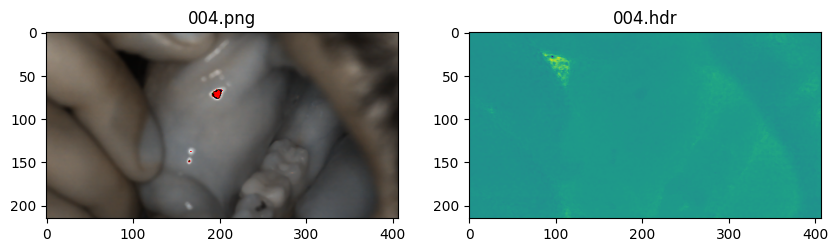

C:\Users\htic\AppData\Local\Temp\ipykernel_29564\3052452885.py:7: RuntimeWarning: invalid value encountered in log
  lnR706 = np.log(img[:,:,10])  #changing reflectance to absorbance
C:\Users\htic\AppData\Local\Temp\ipykernel_29564\3052452885.py:8: RuntimeWarning: invalid value encountered in log
  lnR799 = np.log(img[:,:,4])  #800


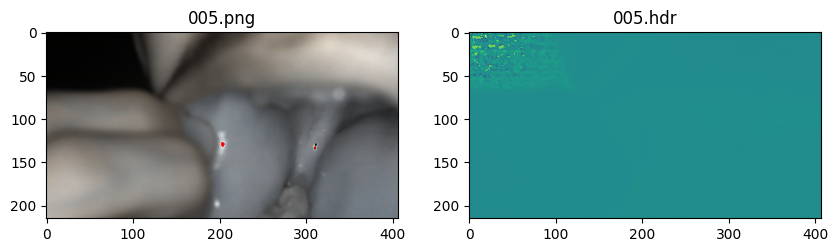

In [71]:
hh_sto2 = []
for i in range(len(hh_imgs)):
    img = hh_imgs[i]
    rgb = hh_rgbs[i]
    Hb,HbO2, StO2 = oxy_cal(img)
    hh_sto2.append(StO2)
    plt.figure(figsize=(10,20))
    plt.subplot(1,2,1), plt.imshow(rgb), plt.title(data_processor.hh_rgbs_name[i])
    plt.subplot(1,2,2), plt.imshow(StO2), plt.title(data_processor.hh_data_name[i])
    plt.show()

In [118]:
mean = []

In [140]:
i = 7
img = leuko_imgs[i]
name = data_processor.leuko_data_name[i]
rgb_img = leuko_rgbs[i]
# mask = data_processor.scc_masks[i]

# To pick points
%matplotlib tk
fig = plt.figure(figsize=(20,30))

ptx = []
pty = []

def onclick(event):
    ix, iy = event.ydata, event.xdata
    ptx.append(ix) #rows
    pty.append(iy) #cols

def on_close(event):
    print('Closed Figure!')
    
#r,g,b = img[:,:,15], img[:,:,7], img[:,:,0]
# rgb_img = np.stack((r,g,b),axis=2)

cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.canvas.mpl_connect('close_event', on_close)
plt.imshow(rgb_img), plt.title('Select the reference region')
plt.show()

IndexError: list index out of range

In [138]:
%matplotlib inline
print("Points Selected",ptx,pty)   
ptx = [int(i) for i in ptx]
pty = [int(i) for i in pty]
print(ptx,pty)

x_len = len(ptx)
x_len = len(ptx)
copy = np.copy(rgb_img)

for i in range(0,len(ptx)-1,2):
    x1 = pty[i]
    y1 = ptx[i]
    x2 = pty[i+1]
    y2 = ptx[i+1]
    cv2.rectangle(copy,(x1,y1),(x2,y2),(255,255,255),2)
    # if i==0:
    #     cv2.putText(copy, "Disease ROI", (x1, y1-5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,255), 2)
    # else:
    #     cv2.putText(copy, "Aparently healthy ROI",(x1, y1-5), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,255), 2)


for i in range(0,len(ptx),2):
    ref_roi_rgb = rgb_img[ptx[i]:ptx[i+1],pty[i]:pty[i+1],:]
    ref_roi_msi = img[ptx[i]:ptx[i+1],pty[i]:pty[i+1],:]
    mean.append(np.mean(ref_roi_msi))

Points Selected [141.56621977434907, 169.46094992177262] [170.18267041479578, 216.94736507371175]
[141, 169] [170, 216]


In [139]:
print(mean)

[0.3160723, 0.26279345, 0.27627063, 0.36612943, 0.4850106, 0.2108986, 0.49273047]


In [ ]:
def analyser(rgbs, imgs, masks, patho):
    #for naming of the plot
    if patho == 0:
        rgbs_name_list = data_processor.leuko_rgbs_name
        data_name_list = data_processor.leuko_data_name
    elif patho == 1:
        rgbs_name_list = data_processor.scc_rgbs_name
        data_name_list = data_processor.scc_data_name
    elif patho == 2:
        rgbs_name_list = data_processor.hh_rgbs_name
        data_name_list = data_processor.hh_data_name


    mean_StO2 = []
    spectral_image_mean = []

    for i in range(len(imgs)):
        image = imgs[i]
        mask = masks[i]
        rgb = rgbs[i]

        Hb, HbO2, StO2 = oxy_cal(image)
        masked_data = cv2.bitwise_and(StO2, StO2, mask = mask)
        # plt.figure(figsize=(45, 15))
        # plt.subplot(1,3,1), plt.imshow(rgb), plt.title(f"RGB of {rgbs_name_list[i]}"),  plt.axis("off")
        # plt.subplot(1,3,3), plt.imshow(masked_data, cmap= 'jet'), plt.title(f"Masked Area StO2 {masks_name_list[i]}"),  plt.axis("off")
        # plt.subplot(1,3,2), plt.imshow(StO2, cmap="jet"), plt.title(f"StO2 of {data_name_list[i]}"), plt.axis("off")
        # name = data_name_list[i]
        # # plt.savefig(f"C:/Users/htic/Desktop/StO2_images/Healthy/{name}.png")
        # plt.show()
        unmasked_pixels = StO2[np.nonzero(StO2)]
        mean_StO2.append(np.mean(unmasked_pixels))

        band_data = []
        for k in range(16):
            band = image[:,:,k]
            #Mask Multiplication
            masking = cv2.bitwise_and(band, band, mask=mask)
            unmasked_area = masking[np.nonzero(masking)]
            band_data.append(np.mean(unmasked_area))

        #normalizing the band data in range 0-1
        norm_band_data = (band_data - np.min(band_data))/(np.max(band_data - np.min(band_data)))
        spectral_image_mean.append(np.array(norm_band_data))

    return mean_StO2, spectral_image_mean

In [ ]:
leuko_mean_StO2, leuko_spectral_img_mean  = analyser(data_processor.leuko_rgbs, data_processor.leuko_imgs, 0)

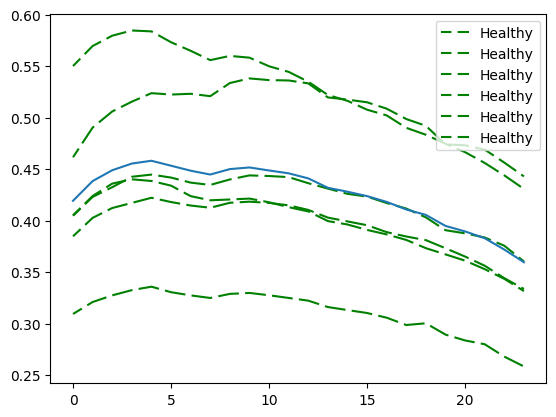

In [16]:
a1 = [0.309464037,	0.32106812,	0.327532754, 0.332605216, 0.335962619,	0.330596748, 0.3275152,	0.325003021, 0.328968966, 0.329887001, 0.327631459,	0.32501503, 0.322394745	,0.316187236, 0.313256465, 0.31040175	, 0.305843744,	0.29873208,	0.300430273,	0.289422033,	0.283745073,	0.280065175,	0.268045999,	0.258476856]
a2 = [0.384862727,	0.402780727, 0.412347034, 0.417307384, 0.422300935,	0.418148211, 0.414767184, 0.412613199, 0.417436036, 0.418508207, 0.417309954, 0.414944971, 0.410512835, 0.403028543, 0.399343179, 0.395624579	, 0.388920067,	0.384692842,	0.38115016,	0.373277812,	0.365192716,	0.356296661,	0.344218363,	0.333757997]
a3 = [0.404854407,	0.423128615, 0.43256779, 0.442687396, 0.444809475,	0.441911509, 0.437011162, 0.434765273, 0.440088196, 0.44402052, 0.443410816, 0.442363472, 0.436443676, 0.43120275, 0.426102772, 0.42343509	, 0.417185899,	0.411818075,	0.40321716,	0.390810607,	0.38774402,	0.38372587,	0.375743421,	0.360492382]
a4 = [0.461627658,	0.490470923, 0.506098117, 0.515630017, 0.523877296,	0.522530057, 0.52327267, 0.520967127, 0.533683894, 0.538200266, 0.536557355, 0.536199101, 0.533376352, 0.519750434, 0.517641189, 0.51501709	, 0.508803367,	0.498747015,	0.49217458,	0.474176369,	0.473244133,	0.469085081,	0.456434408,	0.443040086]
a5 = [0.550179831,	0.569663283, 0.5796753,	0.58474965,	0.583865923, 0.573341719, 0.565031135,	0.555948734, 0.560061351, 0.558347485, 0.549998368, 0.544541141, 0.53500227, 0.522122391, 0.516431708, 0.50782419	, 0.502248119,	0.490207756,	0.483484573,	0.474737112,	0.466562503,	0.456086028,	0.444013648,	0.430855169]
a6 = [0.405252828,	0.424006371, 0.436057347, 0.440233631, 0.438595803, 0.434075136, 0.423904389, 0.419850312,	0.420638967, 0.421513369, 0.417916882, 0.413185244,	0.409052583, 0.399673738, 0.396337091, 0.391077862	, 0.38670313,	0.381363934,	0.373353713,	0.367310069,	0.361232704,	0.352957524,	0.343557132,	0.331686751]

nir_hh_data = [a1,a2,a3,a4,a5,a6]
nir_hh_df = pd.DataFrame(nir_hh_data)
names = ["a1","a2","a3","a4","a5","a6"]
nir_hh_df.insert(loc=0, column = "ID", value = names )
nir_hh_df.to_csv(f"c:/Users/htic/Documents/Jupyter/MSI_Oral_Analysis/nir_healthy.csv")

plt.plot(a1, linestyle = (5, (10, 3)), color= "green", label = "Healthy")
plt.plot(a2, linestyle = (5, (10, 3)), color= "green", label = "Healthy")
plt.plot(a3, linestyle = (5, (10, 3)), color= "green", label = "Healthy")
plt.plot(a4, linestyle = (5, (10, 3)), color= "green", label = "Healthy")
plt.plot(a5, linestyle = (5, (10, 3)), color= "green", label = "Healthy")
plt.plot(a6, linestyle = (5, (10, 3)), color= "green", label = "Healthy")
plt.plot(np.mean(nir_hh_data, axis=0))

plt.legend()



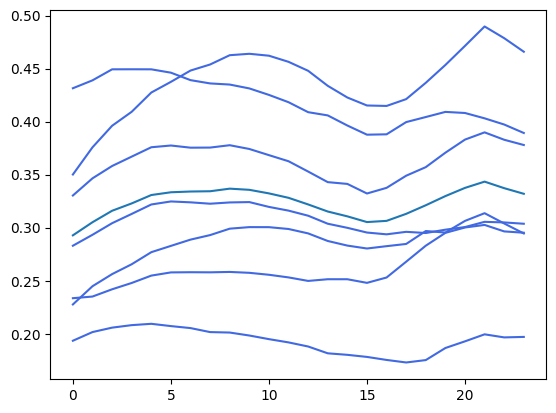

In [17]:
ni3 = [0.28297, 0.293281, 0.304206, 0.312961, 0.321858, 0.324711, 0.323872, 0.322577, 0.323771, 0.324109, 0.319567, 0.316055, 0.311262, 0.303702, 0.299844, 0.295394,	0.29371,	0.296064,	0.29495,	0.298091,	0.30057,	0.305485,	0.304931,	0.303679]
ni4 = [0.330323, 0.346506, 0.358127, 0.366983, 0.375816, 0.377452, 0.375406, 0.375504, 0.377725, 0.374181, 0.368367, 0.362611, 0.352884, 0.342916, 0.341243, 0.332203,	0.337539,	0.348978,	0.357061,	0.370674,	0.383025,	0.38984,	0.382875,	0.377918]
ni5 = [0.233498, 0.235055, 0.241891, 0.247857, 0.254799, 0.257811, 0.257981, 0.257881, 0.258254, 0.257424, 0.255585, 0.253093, 0.249789, 0.251378, 0.251364, 0.247954,	0.253004,	0.267911,	0.282994,	0.295101,	0.300159,	0.302581,	0.296468,	0.295222]
ni6 = [0.2276, 0.244796, 0.256203, 0.265512, 0.276889, 0.282816, 0.288725, 0.292996, 0.299048, 0.300504, 0.300469, 0.298739, 0.294582, 0.28744, 0.283093, 0.280342,	0.282549,	0.284637,	0.296816,	0.295396,	0.306364,	0.313643,	0.303933,	0.29452]
ni7 = [0.350115, 0.375752, 0.396059, 0.409257, 0.427402, 0.437474, 0.448122, 0.453839, 0.462593, 0.46392, 0.462118, 0.456335, 0.447883, 0.433724, 0.422699, 0.415181,	0.414754,	0.421189,	0.436567,	0.453383,	0.47137,	0.489671,	0.478644,	0.465858]
# ni8 = [0.452623, 0.481282, 0.500188, 0.510281, 0.516896, 0.516374, 0.512851, 0.506579, 0.506562, 0.499377, 0.486678, 0.475235, 0.460275, 0.441864, 0.43015, 0.418847,	0.419014,	0.426675,	0.446441,	0.461398,	0.478052,	0.489854,	0.480563,	0.47579]
ni9 = [0.193396, 0.201562, 0.205739, 0.2081, 0.209348, 0.2072, 0.205314, 0.20154, 0.201109, 0.198312, 0.194895, 0.191821, 0.18795, 0.181537, 0.1801, 0.178136,	0.175284,	0.172893,	0.175151,	0.186535,	0.192825,	0.19943,	0.196536,	0.196993,]
ni10 = [0.431441, 0.438894, 0.449272, 0.449318, 0.449269, 0.446109, 0.439075, 0.435982, 0.434915, 0.43127, 0.425157, 0.418263, 0.408867, 0.40583, 0.396298, 0.387658,	0.387993,	0.399533,	0.4043,	0.409137,	0.408108,	0.403069,	0.397234,	0.389253]


nir_leuko_data = [ni3, ni4, ni5, ni6, ni7, ni9, ni10]
nir_leuko_df = pd.DataFrame(nir_leuko_data)
names = ['ni3', 'ni4', 'ni5', 'ni6', 'ni7', ' ni9', 'ni10']
nir_leuko_df.insert(loc=0, column = "ID", value = names )
nir_leuko_df.to_csv(f"c:/Users/htic/Documents/Jupyter/MSI_Oral_Analysis/nir_leuko.csv")


plt.plot(ni3, color= "royalblue", label = "leuko")
plt.plot(ni4, color= "royalblue", label = "leuko")
plt.plot(ni5, color= "royalblue", label = "leuko")
plt.plot(ni6, color= "royalblue", label = "leuko")
plt.plot(ni7, color= "royalblue", label = "leuko")
# plt.plot(ni8,  color= "royalblue", label = "leuko")
plt.plot(ni9,  color= "royalblue", label = "leuko")
plt.plot(ni10,  color= "royalblue", label = "leuko")
plt.plot(np.mean(nir_leuko_data, axis = 0))





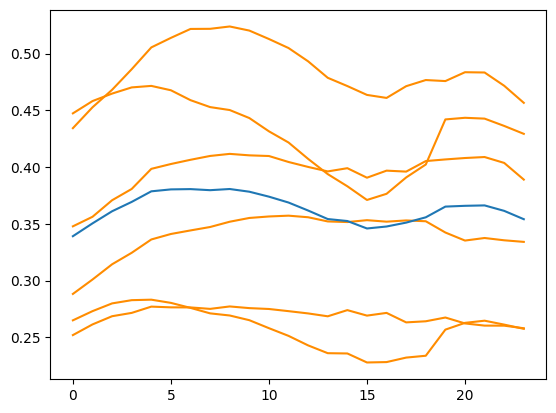

In [9]:
ca_1 = [0.288264,	0.300958,	0.314396,	0.324517,	0.336258,	0.341094,	0.344224,	0.347242,	0.351891,	0.355206,	0.35652,	0.357227,	0.355828,	0.352147,	0.351596,	0.353257,	0.351944,	0.353024,	0.352309,	0.342379,	0.335293,	0.337551,	0.33553,	0.334134]
ca_2 = [0.252001,	0.261402,	0.268629,	0.271559,	0.277088,	0.27645,	0.276376,	0.275097,	0.277246,	0.275769,	0.275,	0.273093,	0.27109,	0.268558,	0.274,	0.269164,	0.271555,	0.263197,	0.264173,	0.267481,	0.262273,	0.260355,	0.260306,	0.258025]
ca_3 = [0.265,	0.273097,	0.27993,	0.282775,	0.283206,	0.280387,	0.275963,	0.271143,	0.269267,	0.265131,	0.258093,	0.251307,	0.242914,	0.236055,	0.235812,	0.227871,	0.228219,	0.232179,	0.233804,	0.256818,	0.26278,	0.26469,	0.261231,	0.257539]
ca_4 = [0.447374,	0.458201,	0.464801,	0.470244,	0.47157,	0.467716,	0.458991,	0.452892,	0.450294,	0.443237,	0.431547,	0.421683,	0.407244,	0.393834,	0.383123,	0.371061,	0.376493,	0.390912,	0.402307,	0.442029,	0.443464,	0.442735,	0.436297,	0.429317]
ca_5 = [0.347834,	0.35624,	0.370821,	0.380767,	0.398481,	0.402746,	0.406465,	0.409846,	0.411671,	0.410379,	0.409788,	0.404524,	0.400164,	0.396213,	0.399061,	0.390682,	0.396899,	0.396051,	0.405335,	0.406781,	0.408028,	0.408892,	0.403708,	0.389003]
ca_6 = [0.434327,	0.452713,	0.46814,	0.48628,	0.505486,	0.513891,	0.521756,	0.521868,	0.523926,	0.520314,	0.512885,	0.504927,	0.493205,	0.478705,	0.471427,	0.46363,	0.460971,	0.471317,	0.476729,	0.475824,	0.483619,	0.48338,	0.471684,	0.456637]


nir_oscc_data = [ca_1, ca_2, ca_3, ca_4, ca_5, ca_6]
nir_oscc_df = pd.DataFrame(nir_oscc_data)
names = ['ca_1', 'ca_2', 'ca_3', 'ca_4', 'ca_5', 'ca_6']
nir_oscc_df.insert(loc=0, column = "ID", value = names )
nir_oscc_df.to_csv(f"c:/Users/htic/Documents/Jupyter/MSI_Oral_Analysis/nir_oscc.csv")


plt.plot(ca_1, color= "darkorange", label = "OSCC")
plt.plot(ca_2, color= "darkorange", label = "OSCC")
plt.plot(ca_3, color= "darkorange", label = "OSCC")
plt.plot(ca_4, color= "darkorange", label = "OSCC")

plt.plot(ca_5, color= "darkorange", label = "OSCC")
plt.plot(ca_6, color= "darkorange", label = "OSCC")

# plt.plot(ni8,  color= "royalblue", label = "leuko")

plt.plot(np.mean(nir_oscc_data, axis = 0))


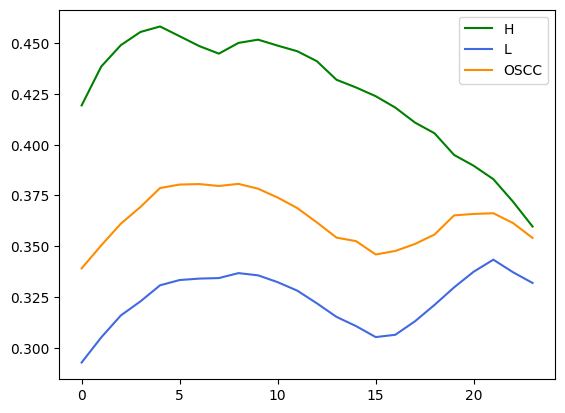

In [14]:
plt.plot(np.mean(nir_hh_data, axis=0), color= "green", label = "H")
plt.plot(np.mean(nir_leuko_data, axis = 0), color= "royalblue", label = "L")
plt.plot(np.mean(nir_oscc_data, axis = 0), color= "darkorange", label = "OSCC")
plt.legend()
plt.savefig("c:/Users/htic/Documents/Jupyter/MSI_Oral_Analysis/NIR_Spectra.png")



In [18]:
import math
from scipy.stats import t

def ttest(dataframe1, dataframe2):
    # dataframe.rename(column = {})
    mean_spectra1 = np.mean(dataframe1, axis=0)
    mean_spectra2 = np.mean(dataframe2, axis=0) #.mean(axis=0)

    std1 = np.std(dataframe1, axis=0) #dataframe1[['{}'.format(i) for i in range(0,16)]].std(axis=0)
    std2 = np.std(dataframe2, axis=0) #dataframe2[['{}'.format(i) for i in range(0,16)]].std(axis=0)

    n1 = len(dataframe1)
    n2 = len(dataframe2)

    degrees_of_freedom = n1 + n2 - 2
    t_value = (mean_spectra1 - mean_spectra2) / np.sqrt((np.divide(std1**2, n1) + np.divide(std2**2, n2)))
    p_value = 2 * (1 - t.cdf(abs(t_value), degrees_of_freedom))

    print(f" t_value: {t_value}")
    print(f" p_value: {p_value}")

    alpha = 0.05
    if np.any(p_value < alpha):
        print("The difference between the two sets of spectral data is statistically significant.")
    else:
        print("Not significant")
    return t_value, p_value


# Converting an array to a dataframe
test = ttest(nir_hh_df, nir_leuko_df)
test = ttest(nir_hh_df, nir_oscc_df)

 t_value: 0     3.022149
1     3.075005
2     2.984297
3     2.961875
4     2.833933
5     2.674670
6     2.549704
7     2.467993
8     2.484764
9     2.542645
10    2.581208
11    2.636830
12    2.724381
13    2.751982
14    2.834228
15    2.922523
16    2.758042
17    2.399638
18    2.074542
19    1.601317
20    1.256219
21    0.947442
22    0.845180
23    0.699569
dtype: float64
 p_value: [0.01161104 0.0105651  0.01242372 0.01293187 0.01625736 0.02161299
 0.02700932 0.03123253 0.03031611 0.02735087 0.02553528 0.02312366
 0.019776   0.01882383 0.0162488  0.01387472 0.01862095 0.03525512
 0.06228261 0.13761108 0.23506111 0.363763   0.41601537 0.49872309]
The difference between the two sets of spectral data is statistically significant.
 t_value: 0     1.831410
1     1.944391
2     1.907425
3     1.824353
4     1.654462
5     1.509740
6     1.393936
7     1.345099
8     1.420106
9     1.510404
10    1.567745
11    1.636227
12    1.720967
13    1.747442
14    1.742940
15    1.814041
16 

C:\Users\htic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\htic\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3603: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [24]:
bands.index(706)

3

In [ ]:
for i in range(len(nir_hh_data)):
    img

In [26]:
def oxy_cal(img):
   # R542 = 52096 , 49708
   # R572 = 49172, 43340 
    attmat = np.array([[52096,49708],[49172,43340]])

    lnR544 = np.log(img[:,:,10])  #changing reflectance to absorbance
    lnR572 = np.log(img[:,:,14])  #800

    has_inf = np.isinf(lnR544).any()

    if has_inf:
        print("The image contains inf values.")
 
    lnR544 = np.nan_to_num(lnR544)
    lnR572 = np.nan_to_num(lnR572)

    # hbO2 = []
    # Hbb = []
    lnR544 = lnR544.reshape(270*510)
    lnR572 = lnR572.reshape(270*510)
    
    y = np.linalg.lstsq(attmat, [lnR544, lnR572])[0]
    hbo2 = y[0]
    hb = y[1]
    hbO2 = hbo2.reshape(270,510)
    Hbb = hb.reshape(270,510)

    #normalizing Hb, Hb02 values before calculating st02
    n_Hb = ((Hbb- Hbb.min())/(Hbb.max()-Hbb.min()))*100
    n_HbO2 = ((hbO2- hbO2.min())/(hbO2.max()-hbO2.min()))*100

    StO2 = n_HbO2/(n_Hb+n_HbO2)
    n_StO2 = ((StO2 - StO2.min()))/(StO2.max() - StO2.min())*100        
    return n_Hb, n_HbO2, n_StO2

In [27]:
def analyser(rgbs, imgs, masks, patho):
    #for naming of the plot
    if patho == 0:
        rgbs_name_list = data_processor.leuko_rgbs_name
        masks_name_list = data_processor.leuko_masks_name
        data_name_list = data_processor.leuko_data_name
    elif patho == 1:
        rgbs_name_list = data_processor.scc_rgbs_name
        masks_name_list = data_processor.scc_masks_name
        data_name_list = data_processor.scc_data_name
    elif patho == 2:
        rgbs_name_list = data_processor.osmf_rgbs_name
        masks_name_list = data_processor.osmf_masks_name
        data_name_list = data_processor.osmf_data_name
    elif patho == 3:
        rgbs_name_list = data_processor.dh_leuko_rgbs_name
        masks_name_list = data_processor.dh_leuko_masks_name
        data_name_list = data_processor.dh_leuko_data_name
    elif patho == 4:
        rgbs_name_list = data_processor.dh_scc_rgbs_name
        masks_name_list = data_processor.dh_scc_masks_name
        data_name_list = data_processor.dh_scc_data_name
    elif patho == 5:
        rgbs_name_list = data_processor.dh_osmf_rgbs_name
        masks_name_list = data_processor.dh_osmf_masks_name
        data_name_list = data_processor.dh_osmf_data_name
    elif patho == 6:
        rgbs_name_list = data_processor.hh_rgbs_name
        masks_name_list = data_processor.hh_masks_name
        data_name_list = data_processor.hh_data_name


    mean_StO2 = []
    spectral_image_mean = []

    for i in range(len(imgs)):
        image = imgs[i]
        mask = masks[i]
        rgb = rgbs[i]

        Hb, HbO2, StO2 = oxy_cal(image)
        masked_data = cv2.bitwise_and(StO2, StO2, mask = mask)
        # plt.figure(figsize=(45, 15))
        # plt.subplot(1,3,1), plt.imshow(rgb), plt.title(f"RGB of {rgbs_name_list[i]}"),  plt.axis("off")
        # plt.subplot(1,3,3), plt.imshow(masked_data, cmap= 'jet'), plt.title(f"Masked Area StO2 {masks_name_list[i]}"),  plt.axis("off")
        # plt.subplot(1,3,2), plt.imshow(StO2, cmap="jet"), plt.title(f"StO2 of {data_name_list[i]}"), plt.axis("off")
        # name = data_name_list[i]
        # # plt.savefig(f"C:/Users/htic/Desktop/StO2_images/Healthy/{name}.png")
        # plt.show()
        unmasked_pixels = StO2[np.nonzero(StO2)]
        mean_StO2.append(np.mean(unmasked_pixels))

        band_data = []
        for k in range(16):
            band = image[:,:,k]
            #Mask Multiplication
            masking = cv2.bitwise_and(band, band, mask=mask)
            unmasked_area = masking[np.nonzero(masking)]
            band_data.append(np.mean(unmasked_area))

        #normalizing the band data in range 0-1
        norm_band_data = (band_data - np.min(band_data))/(np.max(band_data - np.min(band_data)))
        spectral_image_mean.append(np.array(norm_band_data))

    return mean_StO2, spectral_image_mean


In [28]:
#Calculating the StO2 and generating spectral graph - Leuko
leuko_mean_StO2, leuko_spectral_img_mean  = analyser(data_processor.leuko_rgbs, data_processor.leuko_imgs, data_processor.leuko_masks, 0)

AttributeError: 'DataProcessor' object has no attribute 'leuko_masks'

In [ ]:
#Calculating the StO2 and generating spectral graph - SCC
scc_mean_StO2, scc_spectral_img_mean  = analyser(data_processor.scc_rgbs, data_processor.scc_imgs, data_processor.scc_masks, 1)

In [ ]:
#Calculating the StO2 and generating spectral graph - DH-Leuko
dh_leuko_mean_StO2, dh_leuko_spectral_img_mean  = analyser(data_processor.dh_leuko_rgbs, data_processor.dh_leuko_imgs, data_processor.dh_leuko_masks, 3)

In [ ]:
#Calculating the StO2 and generating spectral graph - DH-SCC
dh_scc_mean_StO2, dh_scc_spectral_img_mean  = analyser(data_processor.dh_scc_rgbs, data_processor.dh_scc_imgs, data_processor.dh_scc_masks, 4)

In [ ]:
#Calculating the StO2 and generating spectral graph - Healthy
hh_mean_StO2, hh_spectral_img_mean = analyser(data_processor.hh_rgbs, data_processor.hh_imgs, data_processor.hh_masks, 6)

In [ ]:
bands = [460,462,471,479,489,501,509,518,530,537,548,556,566,576,581,587] #670,682,695,706,722,733,747,761,775,783,799,810,822,837,847,859,871,883,891,906,915,923,931,933]


In [ ]:
#Plotting of Leuko spectral data
# for i in range(len(leuko_spectral_img_mean)):
#     plt.plot(leuko_spectral_img_mean[i])
#     name = data_processor.leuko_data_name[i]
#     plt.title(f"Spectral Graph -Leuko name{name}")
#     # plt.savefig(f"C:/Users/htic/Documents/Jupyter/MSI_Oral_Analysis/{name}.png")
#     plt.show()

# Create a DataFrame from the leuko spectral data
leuko_mean = np.array(leuko_spectral_img_mean)
leuko_mean_df = pd.DataFrame(leuko_mean, columns = (' {}'.format(i) for i in range(0,16)))

name_column = pd.Series(data_processor.leuko_data_name, name='Name')
leuko_mean_df.insert(loc=0, column='Name', value=name_column)


In [ ]:
#Plotting of SCC spectral data
# for i in range(len(scc_spectral_img_mean)):
#     plt.plot(scc_spectral_img_mean[i])
#     name = data_processor.scc_data_name[i]
#     plt.title(f"Spectral Graph -Leuko name{name}")
#     # plt.savefig(f"C:/Users/htic/Documents/Jupyter/MSI_Oral_Analysis/Spectras/SCC/{name}.png")
#     plt.show()

# Create a DataFrame from the leuko spectral data
scc_mean = np.array(scc_spectral_img_mean)
scc_mean_df = pd.DataFrame(scc_mean, columns = (' {}'.format(i) for i in range(0,16)))
name_column = pd.Series(data_processor.scc_data_name, name='Name')
scc_mean_df.insert(loc=0, column='Name', value=name_column)

In [ ]:
#Plotting of DH-Leuko spectral data
# for i in range(len(dh_leuko_spectral_img_mean)):
#     plt.plot(dh_leuko_spectral_img_mean[i])
#     name = data_processor.dh_leuko_data_name[i]
#     plt.title(f"Spectral Graph -Leuko name{name}")
#     # plt.savefig(f"C:/Users/htic/Documents/Jupyter/MSI_Oral_Analysis/Spectras/DH-Leuko/{name}.png")
#     plt.show()

# Create a DataFrame from the leuko spectral data
dh_leuko_mean = np.array(dh_leuko_spectral_img_mean)
dh_leuko_mean_df = pd.DataFrame(dh_leuko_mean, columns = (' {}'.format(i) for i in range(0,16)))
name_column = pd.Series(data_processor.dh_leuko_data_name, name='Name')
dh_leuko_mean_df.insert(loc=0, column='Name', value=name_column)


In [ ]:
#Plotting of DH-SCC spectral data
# for i in range(len(dh_scc_spectral_img_mean)):
#     plt.plot(dh_scc_spectral_img_mean[i])
#     name = data_processor.dh_scc_data_name[i]
#     plt.title(f"Spectral Graph -Leuko name{name}")
#     # plt.savefig(f"C:/Users/htic/Documents/Jupyter/MSI_Oral_Analysis/Spectras/DH-SCC/{name}.png")
#     plt.show()

# Create a DataFrame from the leuko spectral data
dh_scc_mean = np.array(dh_scc_spectral_img_mean)
dh_scc_mean_df = pd.DataFrame(dh_scc_mean, columns = (' {}'.format(i) for i in range(0,16)))
name_column = pd.Series(data_processor.dh_scc_data_name, name='Name')
dh_scc_mean_df.insert(loc=0, column='Name', value=name_column)


In [ ]:
# Plotting of Healthy spectral data
# for i in range(len(hh_spectral_img_mean)):
#     plt.plot(hh_spectral_img_mean[i])
#     name = data_processor.hh_data_name[i]
#     plt.title(f"Spectral Graph -Leuko name{name}")
#     # plt.savefig(f"C:/Users/htic/Documents/Jupyter/MSI_Oral_Analysis/Spectras/HH/{name}.png")
#     plt.show()

heathy_mean = np.array(hh_spectral_img_mean)
hh_df_mean = pd.DataFrame(heathy_mean, columns = (' {}'.format(i) for i in range(0,16)))

writer = pd.ExcelWriter("C:/Users/htic/Documents/Jupyter/MSI_Oral_Analysis/nir_spectras.xlsx")
leuko_mean_df.to_excel(writer, sheet_name="Leuko_Spectra")
scc_mean_df.to_excel(writer, sheet_name="SCC_Spectra")
dh_leuko_mean_df.to_excel(writer, sheet_name="DH_Leuko_Spectra")
dh_scc_mean_df.to_excel(writer, sheet_name="DH_SCC_Spectra")
hh_df_mean.to_excel(writer, sheet_name="Healthy_Spectra")
writer.save()

In [ ]:
xls = pd.ExcelFile("C:/Users/htic/Documents/Jupyter/MSI_Oral_Analysis/Oral_Spectra_02.xlsx")
leuko_df = pd.read_excel(xls, "Leuko_Spectra")
scc_df = pd.read_excel(xls, "SCC_Spectra")
dh_leuko_df = pd.read_excel(xls, "DH_Leuko_Spectra")
dh_scc_df = pd.read_excel(xls, "DH_SCC_Spectra")
hh_df = pd.read_excel(xls, "Healthy_Spectra")

# print(leuko_df)

In [ ]:
def mean_spectra(dataframe):
    # dataframe.rename(column = {})
    mean_spectra = dataframe[[' {}'.format(i) for i in range(0, 16)]].median(axis=0)
    return(mean_spectra)

#Converting an array to a dataframe
leuko_mean_spectra = mean_spectra(leuko_df)
scc_mean_spectra = mean_spectra(scc_df)
dh_leuko_mean_spectra = mean_spectra(dh_leuko_df)
dh_scc_mean_spectra = mean_spectra(dh_scc_df)
hh_mean_spectra = mean_spectra(hh_df)

# print(leuko_mean_spectra)
# print(scc_mean_spectra)
# print(dh_leuko_mean_spectra)
# print(dh_scc_mean_spectra)

#Plotting the results of the mean spectra of each class
plt.plot(leuko_mean_spectra, linestyle = "solid", color = "royalblue",  label = "Leuko")
plt.plot(scc_mean_spectra, linestyle = "dotted", color = "darkorange", label = "SCC")
plt.plot(dh_leuko_mean_spectra, linestyle = (0, (5, 1)), color = "darkorchid",  label = "Aparently Healthy Leuko")
plt.plot(dh_scc_mean_spectra, linestyle = (0, (3, 5, 1, 5)), color = "maroon",  label = "Aparently Healthy OSCC")
plt.plot(hh_mean_spectra, linestyle = (5, (10, 3)), color= "green", label = "Healthy")
plt.savefig(f"C:/Users/htic/Desktop/StO2_images/Median.png")
plt.xlim(0,17)
plt.legend()
plt.show()


In [ ]:
#Reading band 5 and band 8
#R545/R575
def ratio(img, mask):
    band545 =  img[:,:,4] #Corresponds to band 542nm
    band575 = img[:,:,1] #Corresponds to band 575nm

    rat = (band545/band575)
    mask = mask
    masking = cv2.bitwise_and(rat, rat, mask = mask)
    unmasked_area = masking[np.nonzero(masking)]
    # print(f"Mean 545: {np.mean(band545)}, Mean 575: {np.mean(band575)}, Ratio:{np.mean(unmasked_area)}")
    return (np.mean(unmasked_area))

In [ ]:
# Calculate ratios for Leuko images
leukorats = np.array([ratio(img, mask) for img, mask in zip(data_processor.leuko_imgs, data_processor.leuko_masks)])

# Calculate ratios for OSCC images
sccrats = np.array([ratio(img, mask) for img, mask in zip(data_processor.scc_imgs, data_processor.scc_masks)])

# Calculate ratios for DH-Leuko images
dhleukorats = np.array([ratio(img, mask) for img, mask in zip(data_processor.dh_leuko_imgs, data_processor.dh_leuko_masks)])

# Calculate ratios for DH-OSCC images
dhsccrats = np.array([ratio(img, mask) for img, mask in zip(data_processor.dh_scc_imgs, data_processor.dh_scc_masks)])

# Calculate ratios for Healthy images
hhrats = np.array([ratio(img, mask) for img, mask in zip(data_processor.hh_imgs, data_processor.hh_masks)])

In [ ]:
# Calculate ratios for Leuko images
leukorats = np.array([ratio(img, mask) for img, mask in zip(data_processor.leuko_imgs, data_processor.leuko_masks)])

# Calculate ratios for OSCC images
sccrats = np.array([ratio(img, mask) for img, mask in zip(data_processor.scc_imgs, data_processor.scc_masks)])

# Calculate ratios for DH-Leuko images
dhleukorats = np.array([ratio(img, mask) for img, mask in zip(data_processor.dh_leuko_imgs, data_processor.dh_leuko_masks)])

# Calculate ratios for DH-OSCC images
dhsccrats = np.array([ratio(img, mask) for img, mask in zip(data_processor.dh_scc_imgs, data_processor.dh_scc_masks)])

# Calculate ratios for Healthy images
hhrats = np.array([ratio(img, mask) for img, mask in zip(data_processor.hh_imgs, data_processor.hh_masks)])

In [ ]:
#Scatter plot of R545/R575 with all classes -StO2
y1 = np.arange(1, len(leukorats)+1)
y2 = np.arange(1, len(sccrats)+1)
y3 = np.arange(1, len(dhleukorats)+1)
y4 = np.arange(1, len(dhsccrats)+1)
y5 = np.arange(1, len(hhrats)+1)

plt.scatter(y1, leukorats, color = "royalblue", label = "Leuko")
plt.scatter(y2, sccrats, color = "darkorange", label = "SCC")
# plt.scatter(y3, dhleukorats, color = "darkorchid", label = "DH-Leuko")
# plt.scatter(y4, dhsccrats, color = "maroon", label = "DH-Leuko")
plt.scatter(y5, hhrats, color = "green", label = "Healthy")
plt.axhline(np.mean((hhrats)), linestyle = "--", color= "green", label = "HH Mean")
plt.axhline(np.mean((leukorats)), linestyle = "--", color= "royalblue", label = "Leuko Mean")
plt.axhline(np.mean((sccrats)), linestyle = "--", color= "darkorange", label = "SCC Mean")


plt.title("Scatter Plot of /R489")
plt.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

In [ ]:
#Creating a datafram of the StO2 vsalues
leuko_ratio_df =  pd.DataFrame([np.array(leukorats)])
scc_ratio_df = pd.DataFrame([np.array(sccrats)])
dh_leuko_ratio_df = pd.DataFrame([np.array(dhleukorats)])
dh_scc_ratio_df = pd.DataFrame([np.array(dhsccrats)])
hh_ratio_df = pd.DataFrame([np.array(hhrats)])

#Saving the dataframe to an excel file
writer = pd.ExcelWriter("C:/Users/htic/Documents/Jupyter/MSI_Oral_Analysis/DR_B48.xlsx")
leuko_ratio_df.to_excel(writer, sheet_name="Leuko_Ratio")
scc_ratio_df.to_excel(writer, sheet_name="SCC_Ratio")
dh_leuko_ratio_df.to_excel(writer, sheet_name="DH_Leuko_Ratio")
dh_scc_ratio_df.to_excel(writer, sheet_name="DH_SCC_Ratio")
hh_ratio_df.to_excel(writer, sheet_name="Healthy_Ratio")
writer.save()


In [ ]:
from scipy.signal import find_peaks
%matplotlib inline
def perform_peak_analysis(spectra_data):
    # Smooth the spectra data if necessary
    # smoothed_data = smooth_function(spectra_data)  # Replace 'smooth_function' with the appropriate smoothing method

    # Find peaks in the spectra data
    peaks, _ = find_peaks(spectra_data, height=0.51, distance=1) # Adjust 'threshold_value' as needed

    # Retrieve peak positions and intensities
    peak_positions = np.array(range(len(spectra_data)))[peaks]
    peak_intensities = spectra_data[peaks]

    # Perform further analysis on the identified peaks
    # ...

    return peak_positions, peak_intensities

# Perform peak analysis on each dataset
leuko_peak_positions, leuko_peak_intensities = perform_peak_analysis(leuko_mean_spectra)
scc_peak_positions, scc_peak_intensities = perform_peak_analysis(scc_mean_spectra)
dh_leuko_peak_positions, dh_leuko_peak_intensities = perform_peak_analysis(dh_leuko_mean_spectra)
dh_scc_peak_positions, dh_scc_peak_intensities = perform_peak_analysis(dh_scc_mean_spectra)
hh_peak_positions, hh_peak_intensities = perform_peak_analysis(hh_mean_spectra)

# Plot the spectra with identified peaks
plt.plot(leuko_mean_spectra, label='Leuko')
plt.plot(scc_mean_spectra, label='SCC')
plt.plot(dh_leuko_mean_spectra, label='DH Leuko')
plt.plot(dh_scc_mean_spectra, label='DH SCC')
plt.plot(hh_mean_spectra, label='HH')
plt.scatter(leuko_peak_positions, leuko_peak_intensities, color='red', label='Peaks (Leuko)')
plt.scatter(scc_peak_positions, scc_peak_intensities, color='blue', label='Peaks (SCC)')
plt.scatter(dh_leuko_peak_positions, dh_leuko_peak_intensities, color='green', label='Peaks (DH Leuko)')
plt.scatter(dh_scc_peak_positions, dh_scc_peak_intensities, color='orange', label='Peaks (DH SCC)')
plt.scatter(hh_peak_positions, hh_peak_intensities, color='purple', label='Peaks (HH)')
plt.legend()
plt.xlabel('Wavelength/Band')
plt.ylabel('Intensity')
plt.title('Spectra with Identified Peaks')
plt.show()
